In [1]:
%%bash 
cd byoc/smore/
./build_and_push.sh smore-byoc

Login Succeeded

Step 1/7 : FROM ubuntu:18.04
 ---> 2eb2d388e1a2
Step 2/7 : RUN apt-get update &&     apt-get install -y --no-install-recommends         ca-certificates         cmake         build-essential         gcc         g++         git &&     rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 6b10bd703aab
Step 3/7 : RUN git clone https://github.com/cnclabs/smore.git && cd smore && make
 ---> Using cache
 ---> 4a1a0cdeab5a
Step 4/7 : RUN cp -r /smore /app/
 ---> Using cache
 ---> 85af3838711e
Step 5/7 : ENV PATH="/app:${PATH}"
 ---> Using cache
 ---> 115f8bb11eb5
Step 6/7 : WORKDIR /app
 ---> Using cache
 ---> a9bcd1355422
Step 7/7 : COPY train /app/
 ---> Using cache
 ---> 7750dfa47fa2
Successfully built 7750dfa47fa2
Successfully tagged smore-byoc:latest
The push refers to repository [230755935769.dkr.ecr.us-east-1.amazonaws.com/smore-byoc]
10c4e69c1c82: Preparing
04013ad285dd: Preparing
2f63f4856d29: Preparing
6bb22bd7e1ee: Preparing
8682f9a74649: Preparing
d3a6da143c91: Prepa

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [2]:
%env docker_name="230755935769.dkr.ecr.us-east-1.amazonaws.com/smore-byoc"

env: docker_name="230755935769.dkr.ecr.us-east-1.amazonaws.com/smore-byoc"


In [3]:
!pygmentize ./byoc/smore/build_and_push.sh

#!/bin/bash
image=$1
if [ "$image" == "" ]
then
    echo "Usage: $0 <image-name>"
    exit 1
fi
account=$(aws sts get-caller-identity --query Account --output text)
region=$(aws configure get region)
fullname="${account}.dkr.ecr.${region}.amazonaws.com/${image}:latest"

aws ecr describe-repositories --repository-names "${image}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${image}" > /dev/null
fi

$(aws ecr get-login --region ${region} --no-include-email)

docker build -t ${image} . 
docker tag ${image} ${fullname}

docker push ${fullname}


In [4]:
!cat ./byoc/smore/dockerfile

FROM ubuntu:18.04


RUN apt-get update && \
    apt-get install -y --no-install-recommends \
        ca-certificates \
        cmake \
        build-essential \
        gcc \
        g++ \
        git && \
    rm -rf /var/lib/apt/lists/*

RUN git clone https://github.com/cnclabs/smore.git && cd smore && make 

RUN cp -r /smore /app/
ENV PATH="/app:${PATH}"
WORKDIR /app 
COPY train /app/





In [5]:
import sys
sys.path.append('../')

from preprocessing.imdb_datareader import IMDBDataReader
from preprocessing.smore_transformer import SmoreDataTransformer
import pickle 

user_item  = pickle.load(open("data/user_item.p", "rb")) 


users = {}
items = {}
train_user_item = user_item[:int(len(user_item)*0.8)]
test_user_item = user_item[int(len(user_item)*0.8):]
transformer = SmoreDataTransformer(users, items, train_user_item)
X_train, Y_train, _, _, nFeatures = transformer.get_feature_vectors(users, items, train_user_item)
X_test, Y_test,X_cold_test, Y_cold_test, nFeatures = transformer.get_feature_vectors(users, items, test_user_item)

In [6]:
!aws s3api create-bucket --bucket recommendation-demo-yianc-0814 --region us-west-2 --create-bucket-configuration LocationConstraint=us-west-2


An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [7]:
bucket = 'recommendation-demo-yianc'
prefix = 'sagemaker/smore-movielens'
train_key      = 'net'
train_prefix   = '{}/{}'.format(prefix, 'train')
output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)


import io,boto3
import sagemaker.amazon.common as smac

def writeDatasetToSmoreTXT(X, bucket, prefix, key, Y=None):
    f_name = key+".txt"
    f = open(f_name, 'w')
    for i in range(0, len(X)): 
        raw = X[i]
        n1 = raw[0][0]
        n2 = raw[1][0]
        w = Y[i]
        f.write("{} {} {}\n".format(n1, n2, w))
    
    s3_client = boto3.client('s3')
    object_name = '{}/{}'.format(prefix, f_name)
    response = s3_client.upload_file(f_name, bucket, object_name)
 
    return 's3://{}/{}'.format(bucket,object_name)
 
    
train_data = writeDatasetToSmoreTXT(X_train, bucket, train_prefix, train_key,  Y_train)    
  
print('Output: {}'.format(output_prefix))

Output: s3://recommendation-demo-yianc/sagemaker/smore-movielens/output


In [8]:
!cat net.txt | head -n 5

140 1554 1.0
140 1588 1.0
140 1601 1.0
140 1476 1.0
140 1463 1.0
cat: write error: Broken pipe


In [9]:
!docker run -it -v ${PWD}:/opt/ml/input/data/train/ smore-byoc train 


Connections Preview:
	# of connection:	80000
Connections Loading:
	Progress:		100.00 %
	# of vertex:		2367
Build the Alias Method:
	Reconstructing Graph ...
	Building Alias Tables ...
	Finished.
Model Setting:
	dimension:		64
Model:
	[DeepWalk]
Learning Parameters:
	walk_times:		1
	walk_steps:		40
	window_size:		5
	negative_samples:	5
	alpha:			0.025
	workers:		4
Start Training:
	Alpha: 0.025000	Progress: 100.00 %
Save Model:
	Save to </opt/ml/model/rep_dw.txt>


In [10]:
import sagemaker 
from sagemaker import get_execution_role

import boto3 

region = boto3.Session().region_name
crole = get_execution_role()
container = "230755935769.dkr.ecr.us-east-1.amazonaws.com/smore-byoc"
fm = sagemaker.estimator.Estimator(image_name=container,
                                   role=crole, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_prefix,
                                   sagemaker_session=sagemaker.Session())



fm.set_hyperparameters(
                      feature_dim=nFeatures,
                      predictor_type='binary_classifier',
                      mini_batch_size=1000,
                      num_factors=64,
                      epochs=50)

fm.fit({'train': train_data})


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-16 02:44:56 Starting - Starting the training job...
2020-08-16 02:44:59 Starting - Launching requested ML instances.........
2020-08-16 02:46:40 Starting - Preparing the instances for training......
2020-08-16 02:47:39 Downloading - Downloading input data
2020-08-16 02:47:39 Training - Downloading the training image...
2020-08-16 02:48:15 Uploading - Uploading generated training model
2020-08-16 02:48:15 Completed - Training job completed
mkdir: cannot create directory '/opt/ml/model': File exists
Connections Preview:
#011# of connection:#0110#015#011# of connection:#01110000#015#011# of connection:#01120000#015#011# of connection:#01130000#015#011# of connection:#01140000#015#011# of connection:#01150000#015#011# of connection:#01160000#015#011# of connection:#01170000#015#011# of connection:#01179665
Connections Loading:
#011Progress:#011#0110.00 %#015#011Progress:#011#01112.55 %#015#011Progress:#011#01125.10 %#015#011Progress:#011#01137.66 %#015#011Progress:#011#01150.21 %#0

In [11]:
import os 
model_file_name = "model.tar.gz"
model_full_path = fm.output_path +"/"+ fm.latest_training_job.job_name +"/output/"+model_file_name
print ("Model Path: ", model_full_path)

#Download FM model 
os.system("aws s3 cp "+model_full_path+ " .")

#Extract model file for loading to MXNet
os.system("tar xzvf "+model_file_name)



Model Path:  s3://recommendation-demo-yianc/sagemaker/smore-movielens/output/smore-byoc-2020-08-16-02-44-56-181/output/model.tar.gz


0

In [24]:
#Extract model data

import numpy as np 

from preprocessing.smore_datareader import SmoreDataReader


smorereader = SmoreDataReader(transformer.u_idx, transformer.i_idx, "rep_dw.txt")
user_vectors = smorereader.read_user_data()
item_vectors = smorereader.read_item_data()
 

user_inv_idx = {} 
item_inv_idx = {} 

for k, v in transformer.u_idx.items():
    user_inv_idx[v] = k 
    
for k, v in transformer.i_idx.items():
    item_inv_idx[v] = k 
    
    
item_df = pd.read_pickle("data/item_df.p")
genres = ['unknown','Action' , 'Adventure', 'Animation', 'Childrens' , 'Comedy' , 'Crime', \
                                        'Documentary', 'Drama' ,'Fantasy' , 'Film-Noir' , 'Horror' , 'Musical', \
                                        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

vectors_to_visualize = [] 
genre_labels = [] 
for k, v in item_vectors.items(): 
    iid = k
    for index, item_info in item_df[item_df['iid']==int(iid)].iterrows():     
        for g in genres: 
            if item_info[g] > 0:
                vectors_to_visualize.append(numpy.asarray(v)) 
                genre_labels.append(g)
                
    


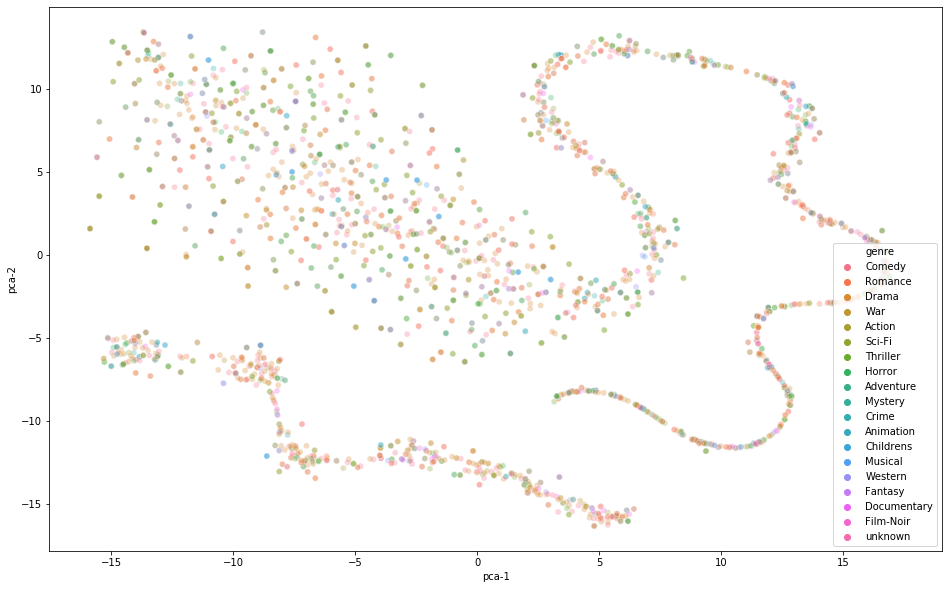

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
vectors_to_visualize = numpy.asarray(vectors_to_visualize)                


pca = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
pca_result = pca.fit_transform(vectors_to_visualize)
d = {} 
d['pca-1'] = pca_result[:,0]
d['pca-2'] = pca_result[:,1]
d['genre'] = genre_labels

df = pd.DataFrame(data=d)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-1", y="pca-2",
    hue="genre",
    data=df,
    legend="full",
    alpha=0.3
)

In [17]:
!pip install annoy 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [19]:
from annoy import AnnoyIndex
#to be modified 
dim = 64
t = AnnoyIndex(dim, 'euclidean')  # Length of item vector that will be indexed
for k, v in item_vectors.items():
    t.add_item(int(k), v)

t.build(100)
t.save('smore.ann')



True

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                                 title
70703                  Ridicule (1996)
70705                  Net, The (1995)
70710              12 Angry Men (1957)
70711             Event Horizon (1997)
70713  Star Trek: First Contact (1996)
...                                ...
70867            Excess Baggage (1997)
70868           Picture Perfect (1997)
70870                    Vermin (1998)
70874          Dangerous Beauty (1998)
70876       Murder in the First (1995)

[87 rows x 1 columns]
                                     title
70702                Ice Storm, The (1997)
70704                   Ulee's Gold (1997)
70707            Return of the Jedi (1983)
70708                  Evil Dead II (1987)
70715                 Jurassic Park (1993)
70716                 Dirty Dancing (1987)
70720                   Ulee's Gold (1997)
70730             Cold Comfort Farm (1995)
70732               River Wild, The (1994)
70733           Spitfire Grill, The (1996)
70734                  Delicatessen 

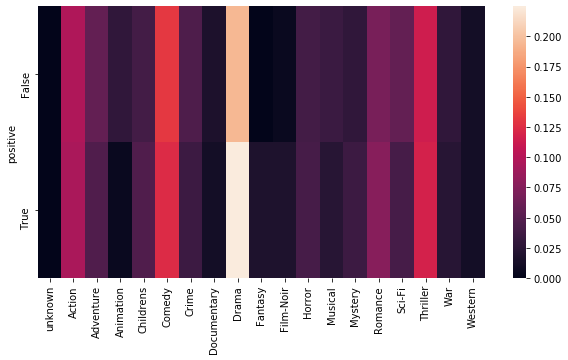

In [20]:
import json

import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


user_item_df = pd.read_pickle("data/user_item_df.p")
item_df = pd.read_pickle("data/item_df.p")
genres = ['unknown','Action' , 'Adventure', 'Animation', 'Childrens' , 'Comedy' , 'Crime', \
                                        'Documentary', 'Drama' ,'Fantasy' , 'Film-Noir' , 'Horror' , 'Musical', \
                                        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


def plot_heat_map(df, figsize=(10,7)): 
    df = df.div(df.sum(axis=1), axis=0)     
    plt.subplots(figsize=figsize)
    sns.heatmap(df)


# test_user_idx = 89
test_user_idx = 200
u_id = user_inv_idx[test_user_idx]

tester_df = user_item_df[user_item_df['uid']==int(u_id)]
tester_df['positive'] = tester_df['rating'] >3 

review = tester_df[['positive']+genres].groupby(['positive']).sum()
plot_heat_map(review, figsize=(10,5))


test_positive_df = user_item_df[(user_item_df['uid']==int(u_id)) & (user_item_df['rating']>3)][['title']]
print(test_positive_df[['title']])
test_negative_df = user_item_df[(user_item_df['uid']==int(u_id)) & (user_item_df['rating']<3)][['title']]
print(test_negative_df[['title']])

nns = t.get_nns_by_vector(user_vectors['200'], 100, search_k=-1, include_distances=False) 
    

print ("Recommended movie Ids for user #{} : {}".format(test_user_idx+1, [movie_id for movie_id in nns]))

for movie_id in nns:
    i_id = movie_id
    print (item_df[item_df['iid']==int(i_id)]['title'])

# print ("Movie distances for user #{} : {}".format(test_user_idx+1,  [round(distance, 4) for distance in u_one_json['distances']]))

In [21]:
genres = item_df[['iid']+genres].set_index('iid')

In [22]:
popularity = user_item_df[user_item_df['rating']>3].groupby('iid').count()['uid'].to_dict() 
answer = {} 
for ui in test_user_item: 
    uid = ui[0]
    iid = ui[1]
    rating = ui[2]
    if uid not in answer:  
        answer[uid] = set() 
    if rating > 0: 
        answer[uid].add(iid)
    
all_pop = 0 
hits = 0 
topk = 10
valid_user_nb = 0 
rcmded = set()
for uid in answer.keys():
    if uid in transformer.u_idx.keys() and uid in user_vectors: 
        nns = t.get_nns_by_vector(user_vectors[uid], 100, search_k=-1, include_distances=False) 
        pred = set()
        valid_user_nb += 1 
        for i, movieid in enumerate(nns[:topk]): 
            rcmded.add(movieid)
            if movieid in popularity: 
                all_pop += popularity[movieid] 
            pred.add(str(movieid))
        hits += len(pred.intersection(answer[uid]))
print(all_pop/topk/valid_user_nb)
print(len(answer))
print(hits)
print(len(rcmded))

46.97592592592592
301
15
441
